<a href="https://colab.research.google.com/github/Heyymant/Halo-trading/blob/main/HaloTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Halo Trading Take Home Assignment
### By Hemant





In [1]:
# !pip install web3

Importing important libraries also  execute the following command to use web3 package
`pip install web3`

Here are all the resources used for the liquidity calculations:\
[Uniswap V3 whitepaper](https://app.uniswap.org/whitepaper-v3.pdf) \
[Uniswap V3 Liquidity Math](https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf)\
[Uniswap V3 Math Primer](https://https://blog.uniswap.org/uniswap-v3-math-primer)\
[Medium Article to calulate accumulated fee](https://https://ryanjameskim.com/uniswap-v3-part-2-ticks-and-fee-acounting-explainer-with-toy-example-e9bf4d706884)\
[Uniswap V3 development book](https://https://uniswapv3book.com/milestone_5/swap-fees.html)

In [2]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from web3 import Web3
from decimal import Decimal

Getting the RPC end point to communicate with ethereum mainnet.

In [3]:
node_url = "https://eth-mainnet.g.alchemy.com/v2/HGQiYNFU4DoY-46wMOxgi6Ol7Y5Sf41f"

In [4]:
# Connect to Ethereum node
web3 = Web3(Web3.HTTPProvider(node_url))
if not web3.is_connected():
    raise Exception("Failed to connect to Ethereum node. Check your URL.")

In [5]:
# the constants
POOL_ADDRESS = "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640"  # address of USDC/WETH pool of 0.05% tier
BLOCK_START = 21241050 # starting block
BLOCK_END = 21241150  # ending block
TICK_LOWER = 195000   # the lower tick
TICK_UPPER = 195070     # the higher tick
TICK_RANGE = range(195000, 195071)  # tick range
INITIAL_USDC = Decimal(50000)  # initial value of usdc
INTITAL_WETH = Decimal(15.5)  # intital value of weth
DEC_USDC = 6   # percise decimal point of USDC notation
DEC_WETH = 18 # precise decimal point of WETH notation
Q96 = 2**96

In [6]:
# uniswap V3 pool abi to extract relevant data from the pool and the block
POOL_ABI = [
    {
        "constant": True,
        "inputs": [],
        "name": "slot0",
        "outputs": [
            {"name": "sqrtPriceX96", "type": "uint160"},
            {"name": "tick", "type": "int24"},
            {"name": "observationIndex", "type": "uint16"},
            {"name": "observationCardinality", "type": "uint16"},
            {"name": "observationCardinalityNext", "type": "uint16"},
            {"name": "feeProtocol", "type": "uint8"},
            {"name": "unlocked", "type": "bool"}
        ],
        "type": "function"
    },
    {
        "constant": True,
        "inputs": [],
        "name": "liquidity",
        "outputs": [{"name": "", "type": "uint128"}],
        "type": "function"
    },
    {
        "constant": True,
        "inputs": [{"name": "tick", "type": "int24"}],
        "name": "ticks",
        "outputs": [
            {"name": "liquidityGross", "type": "uint128"},
            {"name": "liquidityNet", "type": "int128"},
            {"name": "feeGrowthOutside0X128", "type": "uint256"},
            {"name": "feeGrowthOutside1X128", "type": "uint256"}
        ],
        "type": "function"
    },
    {
        "constant": True,
        "inputs": [],
        "name": "token0",
        "outputs": [{"name": "", "type": "address"}],
        "type": "function"
    },
    {
        "constant": True,
        "inputs": [],
        "name": "token1",
        "outputs": [{"name": "", "type": "address"}],
        "type": "function"
    },
    {
        "constant": True,
        "inputs": [],
        "name": "fee",
        "outputs": [{"name": "", "type": "uint24"}],
        "type": "function"
    },

    {
        "constant": True,
        "inputs": [],
        "name": "feeGrowthGlobal0X128",
        "outputs": [{"name": "", "type": "uint256"}],
        "type": "function"
    },
    {
        "constant": True,
        "inputs": [],
        "name": "feeGrowthGlobal1X128",
        "outputs": [{"name": "", "type": "uint256"}],
        "type": "function"
    }

]


Instansiating the pool object to interact with the pool.

In [7]:
# pool object to access the pool data
pool_contract = web3.eth.contract(address=POOL_ADDRESS, abi=POOL_ABI)

Fetching the pool data using the pool object at a given specfic block

In [65]:
def fetch_pool_state(block_number):
    """

    To fetch the pool contract data a givne specific block.

    Arguments : block_number
    Returns : slot0, liquidity

    slot0 contains the pool contract related details such as sqrtPricex96 and current tick
    """
    slot0 = pool_contract.functions.slot0().call(block_identifier=block_number)
    liquidity = pool_contract.functions.liquidity().call(block_identifier=block_number)
    fee= pool_contract.functions.fee().call(block_identifier=block_number)
    sqrtPriceX96 = slot0[0]
    tick = slot0[1]

    price = (sqrtPriceX96 / 2**96) ** 2
    price = price/10**12
    adjprice = 1/price


    return slot0, liquidity

In [9]:
# intial data at first block
s1 = fetch_pool_state(BLOCK_START)
slot0 = s1[0]

# current tick
current_tick = slot0[1]
# liquidity
pool_liquidity  = s1[1]


In [10]:
# function to create the sqrtX96 price to human readable for in USDC format
def price_human(priceX96):
    """
    Arguments : priceX96, price take from the slot0 method call
    Returns : exchange rate in USDC per 1 WETH
    """
    rate = round(10**(DEC_WETH - DEC_USDC)/(priceX96/Q96)**2,6)
    print(f"Corresponding exchange rate is {rate} USDC per 1 WETH")
    return rate

In [11]:
# fucntion to create tick into USDC format price
def tick_to_price(tick):
    """
    Arguments : tick
    Returns : exchange rate(price) in pair format(USDC/WETH) without the decimal truncation
    """
    rate = 1.0001 ** tick
    rate = rate*(10**(DEC_USDC-DEC_WETH))
    rate = 1/rate
    return rate

In [69]:
# lower tick corresponds to the higher price range in our
# example since we have swapped the orientation of the token
# USDC/WETH to WETH/USDC

pb= tick_to_price(TICK_LOWER) # higher price range
pa = tick_to_price(TICK_UPPER) # lower price range
p0 = price_human(slot0[0]) # current price
print(f"Lower Price in range is: {pa} USDC")
print(f"Upper Price in range is: {pb} USDC")
print(f"Current Exchange Price is: {p0} USDC per WETH ")


Corresponding exchange rate is 3389.389423 USDC per 1 WETH
Lower Price in range is: 3377.8557744522827 USDC
Upper Price in range is: 3401.582525304347 USDC
Current Exchange Price is: 3389.389423 USDC per WETH 


We can use the uniswap whitepaper to calculate the liquitdy using the formula.
Using the formula provided in the liquidty math paper we can calculate the amount of an asset required to put liquidity in the pool, corresponding to a given amount of another assets.

Lets see how much of USDC we need to provide for 15.5 WETH of Liquidity to the pool.

First calculate the liquidity of the top half of the range by using the below equation :

$$
L_x = x \frac{\sqrt{p_b} \cdot \sqrt{P}}{\sqrt{p_b} - \sqrt{P}}
$$

and then using this Liquidity we can calculate the y needed:\
$$
y= {L_x}(\sqrt{P} - \sqrt{p_a})
$$

where :\
$ p_a $ = lower price in range \
$ p_b $ = upper price in range \
$ P $ = price at which we want to provide liquidity (defined in form $y/x$) \
$ y $ = Token 1 \
$ x $ = Token 0



In [67]:
# liquidty for a said position,
# liquidty we need to calculate while making a postion in the range
def position_liquidity(x,y,p,pa,pb):
    lx = x*np.sqrt(p)*np.sqrt(pb)/(np.sqrt(pb)- np.sqrt(p))
    ly = y/(np.sqrt(p)-np.sqrt(pa))
    return min(lx,ly)


# for the case where we want to provide liquidity within the range at the current price we can calculate:

# this formula will vary depending on which asset we are choosing
def compute_pair(amount1, current_price, lower_price, upper_price):
    L = amount1 * np.sqrt(current_price) * np.sqrt(upper_price) / (np.sqrt(upper_price) - np.sqrt(current_price))
    y = L * (np.sqrt(current_price) - np.sqrt(lower_price))

    return amount1,y

In [68]:
x0, y0 = compute_pair(15.5, p0, pa, pb)
print(f"Amount of WETH : {x0}")
print(f"Amount of USDC:  {y0}")

Amount of WETH : 15.5
Amount of USDC:  49870.69601537758


Since the price have change we are now calculating the position liquidity to calculate the new asset amounts.
By now using the amount of each token we can get the position liquidity , which is defined as:

$$
L_x = x \frac{\sqrt{p_b} \cdot \sqrt{P}}{\sqrt{p_b} - \sqrt{P}} \\
L_y = \frac{y}{\sqrt{P} - \sqrt{p_a}} \\
L = min(L_x, L_y)
$$

**Note that this is in different units in which the Liquidity is stored. Since we have swapped the pair orientation and using USDC unit for calculation.**

All this math can be seen at the link provided below, where the unit converstion is described in great detail.
[Uniswap V3 Math Notation](https://blog.uniswap.org/uniswap-v3-math-primer)

In [15]:
LIQ = position_liquidity(x0,y0,p0,pa,pb)
print(LIQ)

503036.5162711392


In [16]:
# getting details of second block
s2 = fetch_pool_state(block_number=BLOCK_END)
slot1 = s2[0]
final_tick = slot1[1] # tick at the end block


In [17]:
# final pool price at block 2
p1 = price_human(slot1[0])

Corresponding exchange rate is 3382.819674 USDC per 1 WETH


The price of USDC/WETH has decreased as compared to the previous block.
Since it means the WETH needs to increased in number and USDC must be decreased, to balance the liquidity.

Using position liquidity from the previous calculation to calculate the new asset values after the price change.\

With new price as $\sqrt{P'}$ :

$$
x' = L_pos \frac{\sqrt{p_b} - \sqrt{P'}}{ \sqrt{P'} \cdot \sqrt{p_b}} \\
y' = L_{pos}(\sqrt{P'} - \sqrt{p_a})
$$

In [70]:
# since the liquidity has not during the holding period we can calulate the new
# asset values
# calculating the liquidity of position.

x1 = LIQ *(np.sqrt(pb) - np.sqrt(p1)) /(np.sqrt(p1)* np.sqrt(pb))
y1 = LIQ*(np.sqrt(p1) - np.sqrt(pa))
print(f'New amount of WETH : {x1} WETH')
print(f'New amount of USDC : {y1} USDC')


New amount of WETH : 23.886253862533188 WETH
New amount of USDC : 21473.977028696532 USDC


From this we can clearly see the we provided 15.5 WETH initially, but it has increased due to the price change in pool.

Initially we had 15.5 WETH and 50,000 USDC in our portfolio.

We used our 15.5 WETH and 49870.69601537758 USDC to provide liquidty in pool.
Due to pool price change our assets amount have changed, due to the rebalancing of the pool caused by the extra liquidity or price change.

This creates an issue of impermanent loss.
mpermanent loss is a temporary decrease in the value of assets when a liquidity provider (LP) deposits them into a decentralized finance (DeFi) protocol's liquidity pool:
It occurs when the price of the assets in the pool changes over time, resulting in a discrepancy between the initial deposit and the value at withdrawal. This is because the token ratios in liquidity pools are constantly changing based on trades against them



In [71]:
V_initial = 15.5*p0 + 50000 # the initial value of the portfolio in USDC
print(f" Intial Value of our Portfolio : {V_initial} (USDC)")

 Intial Value of our Portfolio : 102535.5360565 (USDC)


In [91]:
# value(USDC) of our position after the hold period
v_pool = x1*p1 + y1
print(f"Value of our assets in pool after the hold period : {v_pool} (USDC)")

Value of our assets in pool after the hold period : 102276.8665330323 (USDC)


In [92]:
# value(USDC) of our assets if we have held it in our portfolio instead of porviding liquidiy
v_hold = x0*p1 + y0
print(f"Value of our portfolio if we have held outside the pool : {v_hold} (USDC)")

Value of our portfolio if we have held outside the pool : 102304.40096237758 (USDC)


In [93]:
v_final = (x1)*p1 +y1 +50000-y0# total value of our portfolio now without swap fee and gas
print(f"Value of portfolio position after the hold period (without fee) :   {v_final}")

Value of portfolio position after the hold period (without fee) :   102406.17051765471


In [96]:
IL = v_pool- (15.5*p0 + y0)
print(f"Impermanent Loss Occured due to price chage : {IL} USDC")

Impermanent Loss Occured due to price chage : -129.3655388452753 USDC


Now, we have to calculate the liquidty distribution at starting block, spread through out the ticks. We are using the liquidty net value of the ticks to calculate the change in liquidty along with the pool liquidity value.

The logic of this approach can be found [here](https://https://blog.uniswap.org/uniswap-v3-math-primer-2)

In [24]:
liquidity_ticks = []
for i in range(TICK_LOWER,TICK_UPPER+1):
    liq = pool_contract.functions.ticks(i).call(block_identifier= BLOCK_START)[1]
    liquidity_ticks.append(liq)

In [25]:
# current ticks parameters
print(pool_contract.functions.ticks(current_tick).call(block_identifier= BLOCK_START))

[0, 0, 0, 0]


Also due to this process negative liquidity can arises, due to some discripenscy in the Uniswap V3.

To tackle those we are just making the liquidity zero in case it goes negative

[Reference](https://blog.uniswap.org/uniswap-v3-math-primer-2)

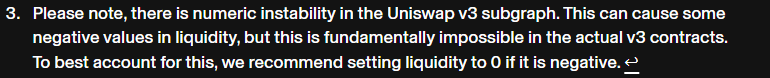

In [26]:
addL = subL = pool_contract.functions.liquidity().call(block_identifier= BLOCK_START) # initialising the amount of liquidity at present

# iteratring through the tick range to calculate the tick liquidity
for i in range(current_tick-TICK_LOWER,-1,-1):
    subL = subL - liquidity_ticks[i]
    if subL <= 0:
        subL = 0
    liquidity_ticks[i] = subL

for i in range(current_tick-TICK_LOWER ,TICK_UPPER-TICK_LOWER+1):
    addL = addL + liquidity_ticks[i]
    if addL <=0:
        addL = 0

    liquidity_ticks[i] = addL




Due the descripency in the units of liquidity , I have plotted different graphs for both liquidity and position liquidity.

In [77]:
def positionLiquidty(x0,y0,lower_tick , upper_tick, current_tick):

    '''
    Calculates the value of postional liquidity in the units
    stored in the contract itself

    Arguments :
    x0 = amount of token0 of pool
    y0 = amount of token1 of pool
    lower_tick = lower tick of the range
    upper_tick = upper tick of the range
    current_tick = current_tick

    Returns : Positional Liquidity in the units of the pool
    '''
    def price(tick):
        return np.sqrt(1.0001**(tick))

    pa = price(lower_tick)
    pb = price(upper_tick)
    p = price(current_tick)
    # print(pa,pb,p)

    lx = x0*(pb*pa)/(pb-p)
    lx = lx*10**6

    ly = y0/(p-pa)
    ly = ly*10**18

    return min(lx,ly)

LIQ_unit = positionLiquidty(y0,x0,TICK_LOWER,TICK_UPPER,current_tick)
print(f"Positional Liquidity (Units of pool) : {LIQ_unit}")

Positional Liquidity (Units of pool) : 4.8906718281745517e+17


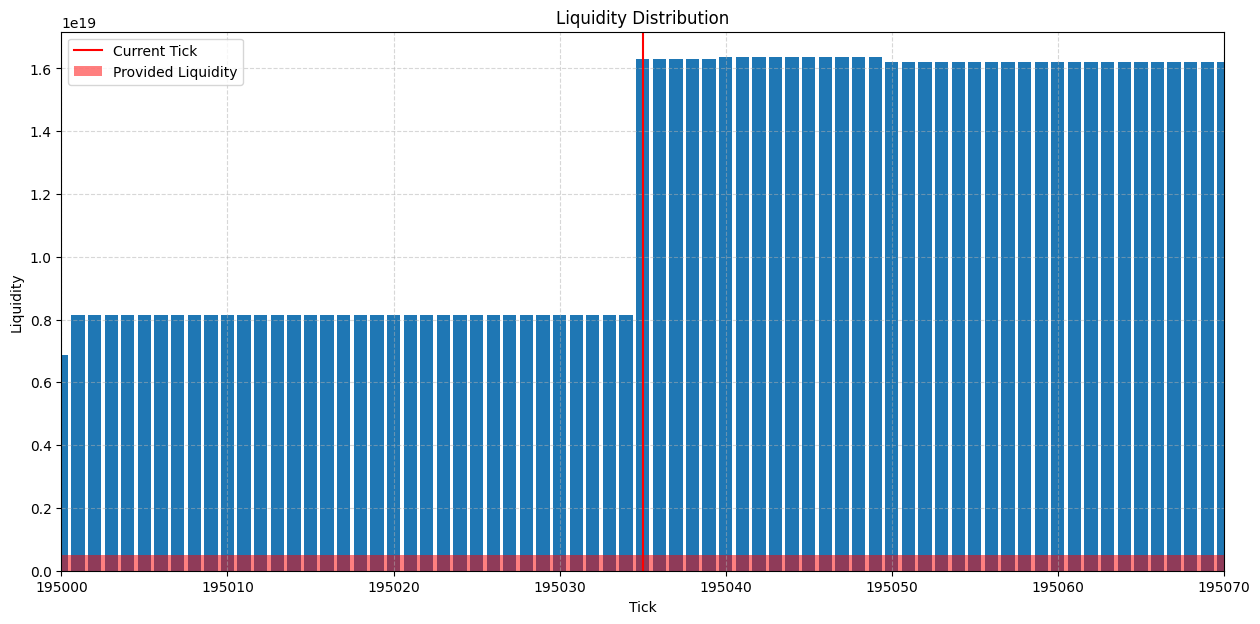

In [78]:
plt.figure(figsize=(15, 7))

ticks = list(range(TICK_LOWER, TICK_UPPER + 1))
plt.bar(ticks,liquidity_ticks)
plt.xlim(TICK_LOWER, TICK_UPPER)
plt.axvline(x=current_tick, color='r', linestyle='-', label='Current Tick')
plt.xlabel("Tick")
plt.ylabel("Liquidity")
plt.title("Liquidity Distribution")
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.axhspan(0, LIQ_unit, color='red', alpha=0.5, lw=0,label = "Provided Liquidity")  #uncomment this line for same unit liquidity
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


Now to calculate the swap fee, we need to see how the fee has grown in the region of our acceptable price range.

The growth of the fees in the global region can be extracted from the pool data.

`feeGrowthGlobal0X128` value of global fee growth for token0
`feeGrowthGlobal1X128` value of global fee growth for token1

Note : they are stored in x128 format need to divide by $2^{128}$.


In [79]:
t = []  # tick in order of price traversal
fg0= [] # global fees for token0 during price change
fg1= [] # global fees for token1 during price change
for i in range(BLOCK_START,BLOCK_END+1):
    t.append(pool_contract.functions.slot0().call(block_identifier=i)[1])
    fg0.append(pool_contract.functions.feeGrowthGlobal0X128().call(block_identifier=i))
    fg1.append(pool_contract.functions.feeGrowthGlobal1X128().call(block_identifier=i))


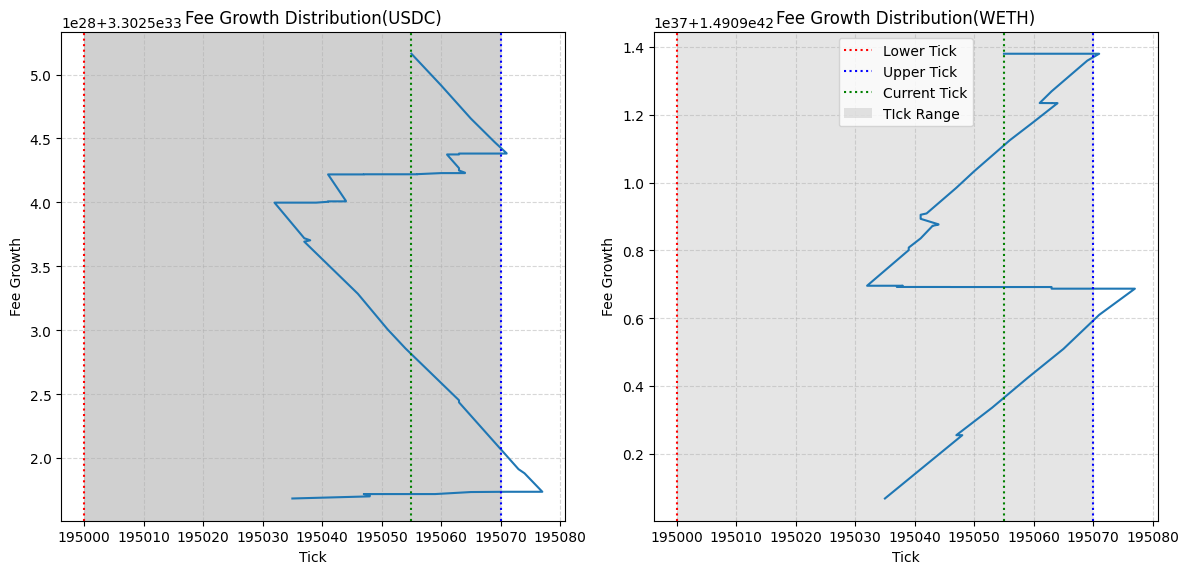

In [80]:
 # Convert fg to a numpy array if it's not already
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.axvspan(TICK_LOWER, TICK_UPPER, color='grey', alpha=0.2, lw=0)
plt.plot(t, fg0)
plt.xlabel("Tick")
plt.ylabel("Fee Growth")
plt.title("Fee Growth Distribution(USDC)")
plt.axvline(x=TICK_LOWER, color='r', linestyle=':', label='Lower Tick')
plt.axvline(x=TICK_UPPER, color='b', linestyle=':', label='Upper Tick')
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.axvline(x=t[-1], color='g', linestyle=':', label='Upper Tick')
plt.axvspan(TICK_LOWER, TICK_UPPER, color='grey', alpha=0.2, lw=0)
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1,2,2)
plt.plot(t,fg1)
plt.xlabel("Tick")
plt.ylabel("Fee Growth")
plt.title("Fee Growth Distribution(WETH)")
plt.axvline(x=TICK_LOWER, color='r', linestyle=':', label='Lower Tick')
plt.axvline(x=TICK_UPPER, color='b', linestyle=':', label='Upper Tick')
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.axvline(x=t[-1], color='g', linestyle=':', label='Current Tick')
plt.axvspan(TICK_LOWER, TICK_UPPER, color='grey', alpha=0.2, lw=0, label = "TIck Range")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

The above graph depicts the growth in global fee during price change.
As we can see the fees is constantly increasing since its global fee.
The fee growth can be explained from the picture below.

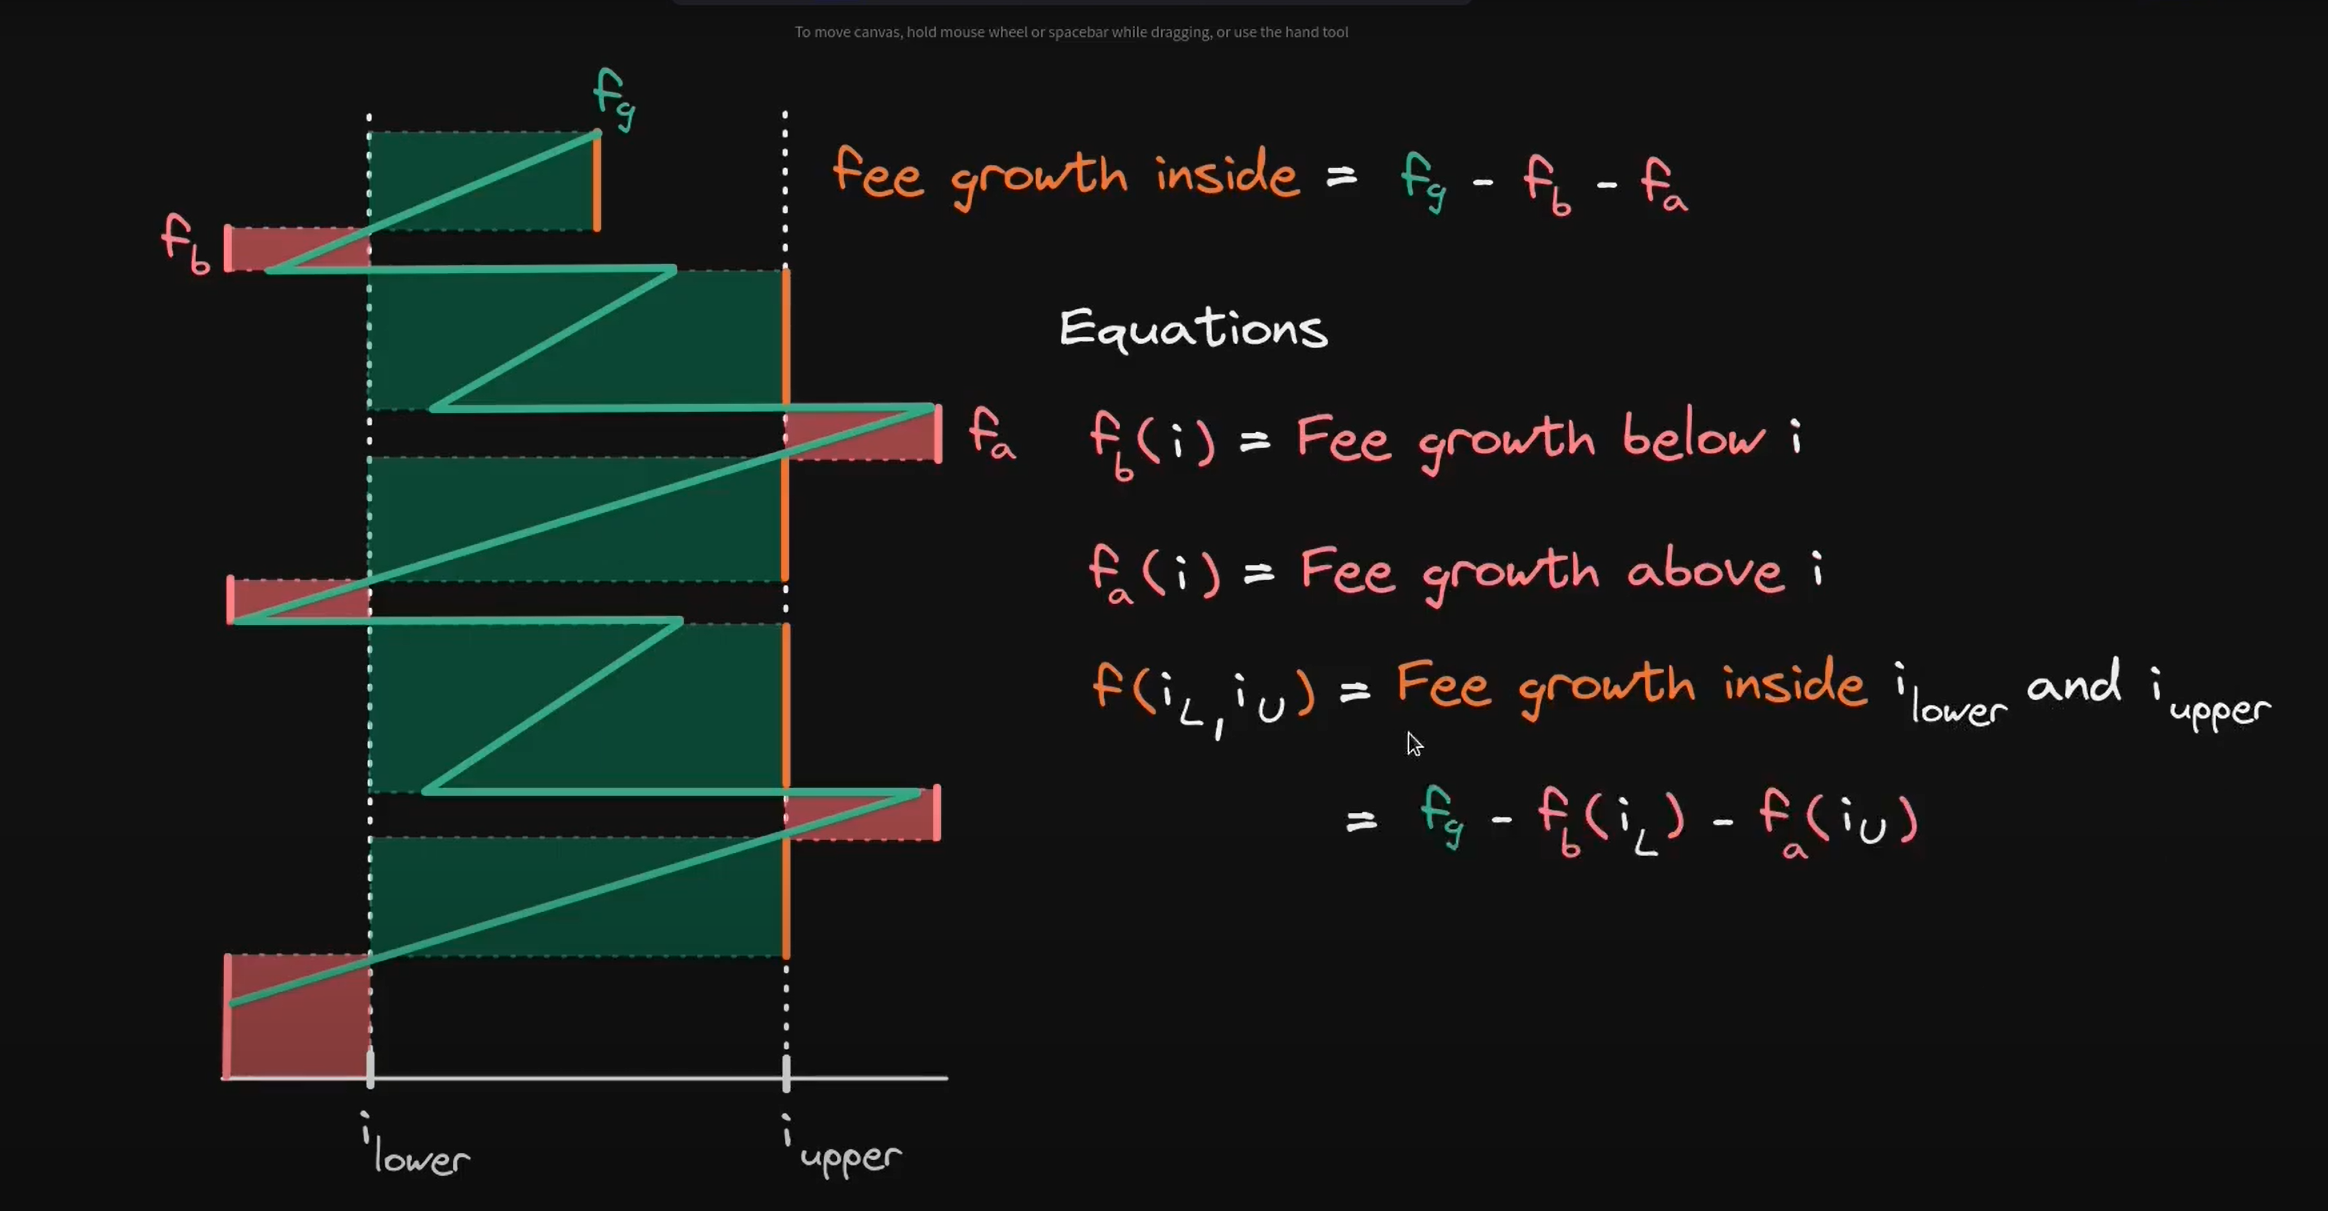

In [81]:
min_cross = min(t) # the tick crossed on the left most side during the price movement.
print(f"Left most tick touched during the price movement : {min_cross}"))

195032


The above graph tells us about the growth of fee globally, we can use it to calculate the fee in the region by using the relation given below
$
feeInside = feeGlobal - feeOutsideLower -feeOutsideUpper
$

Key Assumptions :
1. Here the intial feeOutside for lower and upper tick are not initialized since they we not crossed at zero. But we are provided with the data in the tick.

2. To get the feeGrowth inside the position from the starting point we have to subtract the initial feeGrowth at tick0(starting tick) to get the amount of growth we saw during the price change.

3. Also the price did not cross the lower tick ever, so the there is not growthOutside the lower tick.

4. But for our case `feeGrowthOutside` are initialized for both lower and upper tick. So we will also subtract them as well at the starting time too .

In [82]:
# feeGrowthOutside at tick for token0 and token1
fa0 = pool_contract.functions.ticks(TICK_UPPER).call(block_identifier=BLOCK_START)[2]
fa1 = pool_contract.functions.ticks(TICK_UPPER).call(block_identifier=BLOCK_START)[3]

fb0 = pool_contract.functions.ticks(TICK_LOWER).call(block_identifier=BLOCK_START)[2]
fb1 = pool_contract.functions.ticks(TICK_LOWER).call(block_identifier=BLOCK_START)[3]

# storing the intial value for using it later
# to calculate the fees occured between two price changes
fa0_t0 = fa0
fa1_t0 = fa1

fb0_t0 = fb0
fb1_t0 = fb1

def fee_above(TICK_UPPER,f0,f1):
    """
    Calculates the fee growth above the upper level tick.
    Arguments : Upper tick, initial fee growthOutside for token0 an token1
    Returns : final feegrowthOutisde for each token as well updates

    """
    for i in range(len(t)):
        current_tick = t[i]
        g0 = fg0[i]
        g1 = fg1[i]
        if current_tick >= TICK_UPPER:
            f0 = g0 -f0
            f1 = g1 -f1
        else:
            f0 = f0
            f1 = f1

    return f0,f1

def fee_below(TICK_LOWER,f0,f1):

    """
    Calculates the fee growth below the lower level tick.
    Arguments : Lower tick, initial fee growthOutside for token0 an token1
    Returns : final feegrowthOutisde for each token as well as updates

    """
    for i in range(len(t)):
        current_tick = t[i]
        g0 = fg0[i]
        g1 = fg1[i]
        if current_tick < TICK_LOWER:
            f0 = g0 -f0
            f1 = g1 -f1
        else:
            f0 = f0
            f1 = f1

    return f0,f1

# swapFee = fg0[-1] - fee_below(TICK_LOWER, fa0,fa1)[0] - fee_above(TICK_UPPER, fb0,fb1)[0]

# swap fee accured during the price movement
#swap fee = (fee at t1 - fee at t0)
# here we are subtracting the fees related to the intial price (t_0 event)
# also the intial value of feeGrowthOutside are initialiazed for both tick.
swapFee0 = (fg0[-1] -fee_below(TICK_LOWER, fb0,fb1)[0] - fee_above(TICK_UPPER, fa0,fa1)[0] - (fg0[0] -fa0_t0 - fb0_t0))/2**128

swapFee1 = (fg1[-1] - fee_below(TICK_LOWER, fb0,fb1)[1] - fee_above(TICK_UPPER, fa0,fa1)[1] - (fg1[0] -fa1_t0 - fb1_t0))/2**128


Assuming the swap fee is distributed evenly among the crossed ticks.

I have assumed to distribute the swap fees equally for the crossed range.
For crossed range, here i am taking checking the range of tick which were crossed during the price movement.

In [84]:
crossRange = TICK_UPPER - min_cross+1
# the fee distriution
fee_distribution0 = [0]*(TICK_UPPER - TICK_LOWER +1)
for i in range(min_cross-TICK_LOWER, TICK_UPPER-TICK_LOWER+1):
    fee_distribution0[i] = swapFee0/crossRange

fee_distribution1 = [0]*(TICK_UPPER - TICK_LOWER +1)
for i in range(min_cross-TICK_LOWER, TICK_UPPER-TICK_LOWER+1):
    fee_distribution1[i] = swapFee1/crossRange

Key Assumptions:
1. Liquidity of the pool is same during the hold period. So we can use the previous liquidity caclulated on each tick.

2. Swap fee allocation is propotional to the liquidity weight on each tick.

In [85]:
swapLiq0 = [(x*y)/10**6 for x, y in zip(fee_distribution0,liquidity_ticks) ] # USDC uses 6 decimal places
swapLiq1 = [(x*y)/10**18 for x, y in zip(fee_distribution1,liquidity_ticks) ] # WETH uses 18 decimal places

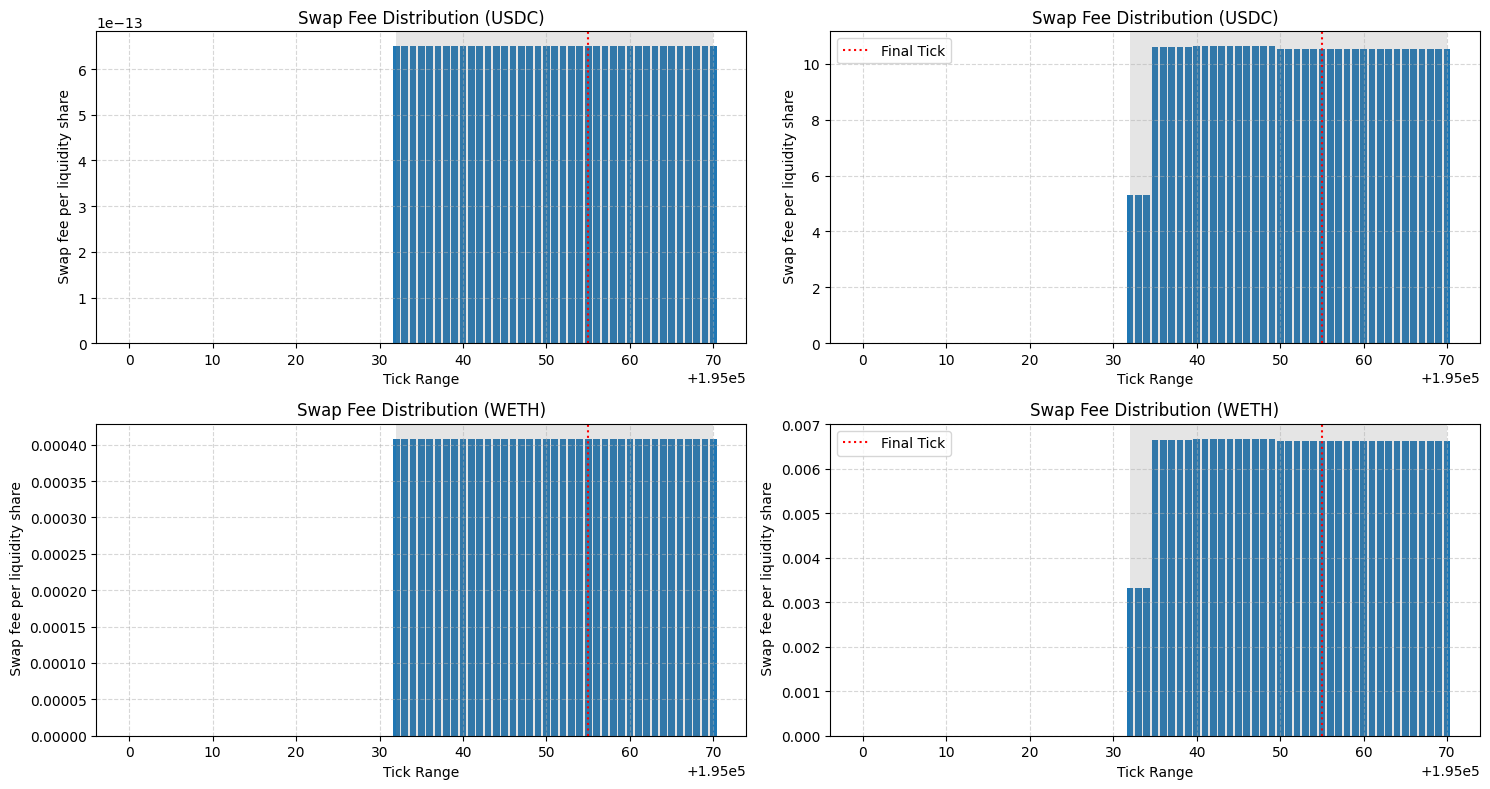

In [86]:
plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
plt.bar(ticks,fee_distribution0)
plt.xlabel("Tick Range")
plt.ylabel(" Swap fee per liquidity share")
plt.title("Swap Fee Distribution (USDC)")
plt.axvspan(min_cross, TICK_UPPER, color='grey', alpha=0.2, lw=0)
plt.axvline(x=t[-1], color='r', linestyle=':', label='Final Tick')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,2)
plt.bar(ticks,swapLiq0)
plt.xlabel("Tick Range")
plt.ylabel(" Swap fee per liquidity share")
plt.title("Swap Fee Distribution (USDC)")
plt.axvspan(min_cross, TICK_UPPER, color='grey', alpha=0.2, lw=0)
plt.axvline(x=t[-1], color='r', linestyle=':', label='Final Tick')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()


plt.subplot(2,2,3)
plt.bar(ticks,fee_distribution1)
plt.xlabel("Tick Range")
plt.ylabel(" Swap fee per liquidity share")
plt.title("Swap Fee Distribution (WETH)")
plt.axvspan(min_cross, TICK_UPPER, color='grey', alpha=0.2, lw=0)
plt.axvline(x=t[-1], color='r', linestyle=':', label='Final Tick')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,4)
plt.bar(ticks,swapLiq1)
plt.xlabel("Tick Range")
plt.ylabel(" Swap fee per liquidity share")
plt.title("Swap Fee Distribution (WETH)")
plt.axvspan(min_cross, TICK_UPPER, color='grey', alpha=0.2, lw=0)
plt.axvline(x=t[-1], color='r', linestyle=':', label='Final Tick')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.tight_layout()
plt.show()


Due to equaly distribution of swap fee, the Swap Fee Distribution curve closely follow the liquidation curve.

The above graph shows total fees increased since we are using the total liquidity at ticks, we will only get a share of these fees depending on our share.

Portfolio PnL can be thought of as starting portfolio value and then comparing it with the final portfolio value adding fees.

Since the gas fee and transaction fees are assummed to be zero we dont have to calculate that.

The equation of final portfolio will look like:\
$$
V_{final} = Amount_{WETH} *  Price_{WETH} + Amount_{USDC} + remainingFunds+ feeAccured
$$

In [59]:
feeUSDC = swapFee0*LIQ_unit/10**6
feeWETH = swapFee1*LIQ_unit/10**18
print(f"Fees accurred in USDC : {feeUSDC} USDC")
print(f"Fees accurred in WETH : {feeWETH} WETH")

Fees incurred in USDC : 12.399730283602825
Fees incurred in WETH : 0.007787069184827515


In [60]:
V_final = x1*p1 + y1 + 50000 -y0 + feeUSDC + feeWETH*p1
print(f"Final value of our portfolio (including fees) : {V_final} USDC")

Final value of our portfolio (including fees) : 102444.91249877955 USDC


In [58]:
PnL = V_final - V_initial
print(f"The PnL of our portfolio is {V_final- V_initial} (USDC)")

The PnL of our portfolio is -90.62355772044975 (USDC)


Sadly we are making a loss!